Bi-LSTM with attention classifier, for gender

In [4]:
import bilstm_classifier
from format import *
import features
import torch
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import re # tokenize
%matplotlib inline

Get the training and test data.

In [5]:
df_train, df_test = get_text_to_gender()
df_train = df_train.where(df_train['content'].apply(lambda x: isinstance(x, str) and x.strip() != '')).dropna()

df_test = df_test.where(df_test['content'].apply(lambda x: isinstance(x, str) and x.strip() != '')).dropna()

gender_map = {'M': 0, 'F': 1}
df_train['gender'] = df_train['gender'].map(gender_map)
df_train = df_train.dropna(subset=['gender'])
df_train = df_train.dropna(subset=['rhyme'])
df_train = df_train.dropna(subset=['met'])

df_test['gender'] = df_test['gender'].map(gender_map)
df_test = df_test.dropna(subset=['gender'])
df_test = df_test.dropna(subset=['rhyme'])
df_test = df_test.dropna(subset=['met'])

Tokenize input

In [67]:
f_tokenize = lambda x: re.findall(r'\b\w+\b', x.lower())
train_tokens = df_train['content'].apply(f_tokenize)
test_tokens = df_test['content'].apply(f_tokenize)

In [7]:
print(train_tokens.head())

0    [mi, palabra, tenaz, como, el, cincel, fue, mo...
1    [la, muda, soledad, del, firmamento, como, un,...
2    [quién, artista, sublime, conmovido, no, se, s...
3    [nos, pusimos, de, acuerdo, sin, habernos, hab...
4    [contendían, los, dioses, soberanos, del, ciel...
Name: content, dtype: object


Create vocabulary (we can reuse the n-gram code). We can have |vocab| = 10k so that we can represent most of the words.

In [8]:
vocab, _ = features.get_top_n_vocab(df_train['content'], n=10000)

In [9]:
print(vocab[:10])
vocab.append('<PAD>')
vocab.append('<UNK>')
print(len(vocab))

word_to_ix = {word: idx for idx, word in enumerate(vocab)}
PAD = word_to_ix['<PAD>']
UNK = word_to_ix['<UNK>']
print(PAD)
print(UNK)

['de', 'la', 'y', 'el', 'que', 'en', 'a', 'su', 'del', 'al']
10002
10000
10001


In [10]:
!curl -O http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   275  100   275    0     0    705      0 --:--:-- --:--:-- --:--:--   705


In [60]:
reload(bilstm_classifier);
from torch.nn.utils.rnn import pad_sequence
word_embed = bilstm_classifier.build_embed_matrix(word_to_ix, 'glove-sbwc.i25.vec.gz', 300)

In [ ]:
def collate(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=PAD)
    return padded_seqs, torch.stack(labels), lengths

class TextData(torch.utils.data.Dataset):
    def __init__(self, texts, labels, word_to_ix, unk_idx):
        self.texts = texts  # list of token lists
        self.labels = labels  # list of ints
        self.word_to_ix = word_to_ix
        self.unk_idx = unk_idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx]
        label = self.labels[idx]
        indices = [self.word_to_ix.get(tok, self.unk_idx) for tok in tokens]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)


In [62]:
#train_indices = train_tokens.apply(lambda tokens: [word_to_ix.get(tok, UNK) for tok in tokens])
train_dataset = TextData(train_tokens.tolist(), df_train['gender'].tolist(), word_to_ix, UNK)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate)

In [ ]:
model = bilstm_classifier.BiLSTM(
    vocab_size=len(word_to_ix),
    embedding_dim=300,
    hidden_dim=128,
    num_classes=len(gender_map),
    pad_idx=PAD,
    embeddings=word_embed
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# train
for epoch in range(5):
    model.train()
    correct = total = 0
    for input, labels, lengths in train_loader:
        optimizer.zero_grad()
        outputs = model(input, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

Training accuracy: 0.9318
Epoch 1: loss = 0.0607
Training accuracy: 0.9318
Epoch 2: loss = 0.2314
Training accuracy: 0.9345
Epoch 3: loss = 0.1238
Training accuracy: 0.9741
Epoch 4: loss = 0.0674
Training accuracy: 0.9918
Epoch 5: loss = 0.0044
Training accuracy: 0.9978
Epoch 6: loss = 0.1784
Training accuracy: 0.9980
Epoch 7: loss = 0.0003
Training accuracy: 0.9988
Epoch 8: loss = 0.0044
Training accuracy: 0.9980
Epoch 9: loss = 0.0008
Training accuracy: 0.9990
Epoch 10: loss = 0.0001


Try eval on test set!

In [83]:
test_dataset = TextData(test_tokens.tolist(), df_test['gender'].tolist(), word_to_ix, UNK)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate)
model.eval()  # set to eval mode
correct = total = 0
with torch.no_grad():
    for input, labels, lengths in test_loader:
        optimizer.zero_grad()
        outputs = model(input, lengths)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        print(predicted) # is this another majority class issue?
        total += labels.size(0)

test_accuracy = correct / total
print(f"Final test accuracy: {test_accuracy:.4f}")

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0,

Let's try to weight loss to minimize auto-assigning to the majority class.

In [91]:
model = bilstm_classifier.BiLSTM(
    vocab_size=len(word_to_ix),
    embedding_dim=300,
    hidden_dim=128,
    num_classes=len(gender_map),
    pad_idx=PAD,
    embeddings=word_embed
)

#### This part is different: we use class weights
train_labs = df_train['gender'].tolist()
class_count = np.bincount(train_labs, minlength=len(gender_map))

# normalized inverse class weight
class_weights = torch.Tensor(len(train_labs) / (len(gender_map) * class_count))
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# train
for epoch in range(5):
    model.train()
    correct = total = 0
    for input, labels, lengths in train_loader:
        optimizer.zero_grad()
        outputs = model(input, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

Training accuracy: 0.8110
Epoch 1: loss = 0.5790
Training accuracy: 0.7918
Epoch 2: loss = 0.7334
Training accuracy: 0.7601
Epoch 3: loss = 0.6761
Training accuracy: 0.8239
Epoch 4: loss = 0.8677
Training accuracy: 0.9173
Epoch 5: loss = 0.3220


In [92]:
# eval again
test_dataset = TextData(test_tokens.tolist(), df_test['gender'].tolist(), word_to_ix, UNK)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate)
model.eval()  # set to eval mode
correct = total = 0
actuals = []
expected= []
with torch.no_grad():
    for input, labels, lengths in test_loader:
        optimizer.zero_grad()
        outputs = model(input, lengths)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        actuals.append(predicted)
        expected.append(labels)
        print(predicted) # is this another majority class issue?
        total += labels.size(0)

test_accuracy = correct / total
print(f"Final test accuracy: {test_accuracy:.4f}")

tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0,

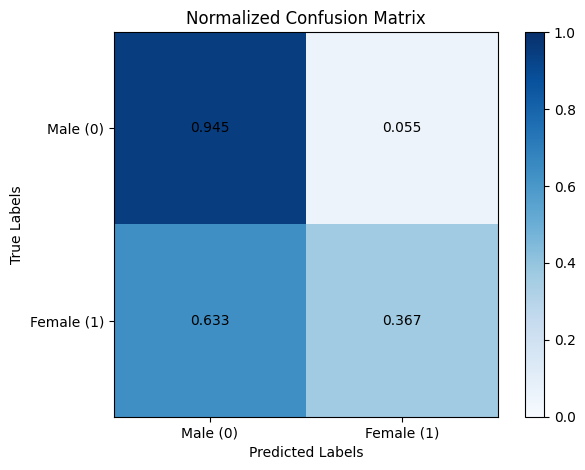

In [93]:
# visualize the splits for errors
actuals = torch.cat(actuals).detach().cpu().tolist()
expecteds = torch.cat(expected).detach().cpu().tolist()

# Initialize confusion matrix: [actual][predicted]
mtrx = [[0, 0],
      [0, 0]]

for actual, expected in zip(actuals, expecteds):

    mtrx[int(expected)][int(actual)] += 1

mtrx = np.array(mtrx)

# Normalize each row (i.e., per actual class)
mtrx_normal = (1.0* mtrx) / mtrx.sum(axis=1, keepdims=True)

fig, ax = plt.subplots()
im = ax.imshow(mtrx_normal, cmap='Blues', vmin=0, vmax=1)

# Labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Male (0)', 'Female (1)'])
ax.set_yticklabels(['Male (0)', 'Female (1)'])
for i in range(2):
    for j in range(2):
        value = mtrx_normal[i, j]
        ax.text(j, i, f'{value:.3f}', ha='center', va='center', color='black')

plt.colorbar(im)
plt.tight_layout()
plt.show()